# Phase 5: Model Training V1b — Multi-Pattern Binary Classifier

**Goal:** Train XGBoost to predict win/loss for 2R trades across 3 pattern types and 6 pairs

**Dataset:** ~1,200 labeled patterns (pin_bar + double_top + double_bottom) across EUR/USD, GBP/USD, USD/JPY, AUD/USD, EUR/GBP, USD/CAD

**Previous V1:** 194 pin bars, AUC 0.51 (random). This V1b has 6x more data and pattern diversity.

In [1]:
# Cell 1: Load & Clean Data
import pandas as pd
import numpy as np

CSV_PATH = "/Users/muftau/Documents/programming/trading-ai/python/data/training-all-1132.csv"

df_raw = pd.read_csv(CSV_PATH)
print(f"Loaded {len(df_raw)} rows, {len(df_raw.columns)} columns")
print(f"Outcome distribution:\n{df_raw.outcome.value_counts()}")

# Filter out "pending" outcomes (trades where neither TP nor SL was hit)
df_raw = df_raw[df_raw["outcome"].isin(["win", "loss"])].reset_index(drop=True)
print(f"\nAfter filtering pending: {len(df_raw)} rows")

df = df_raw.copy()

# --- Drop 100% null columns ---
df = df.drop(columns=["volume", "volume_sma"])

# --- Separate metadata, target, and analysis-only columns ---
metadata_cols = [
    "id", "pair", "pattern_type", "start_timestamp", "end_timestamp",
    "entry_price", "stop_loss", "take_profit", "notes",
    "nearest_round_number", "nearest_support", "nearest_resistance",
]
target_col = "outcome"
# Future-leaking: only known after the trade
analysis_only_cols = ["r_multiple", "bars_to_outcome", "max_favorable_excursion"]

# --- Encode target ---
df["target"] = (df["outcome"] == "win").astype(int)

# --- Encode categoricals ---
df["trend_state"] = df["trend_state"].fillna("unknown")
df["trading_session"] = df["trading_session"].fillna("unknown")

# Keep original categoricals before one-hot encoding
df_raw["trend_state"] = df_raw["trend_state"].fillna("unknown")
df_raw["trading_session"] = df_raw["trading_session"].fillna("unknown")

# One-hot encode pattern_type (new feature), trend_state, trading_session
df = pd.get_dummies(df, columns=["pattern_type", "trend_state", "trading_session"], dtype=int)

# --- Build feature matrix ---
drop_cols = metadata_cols + [target_col] + analysis_only_cols + ["target", "quality_rating"]
feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols]
y = df["target"]

print(f"\nFeature matrix: {X.shape}")
print(f"Features ({len(feature_cols)}): {feature_cols}")
print(f"\nTarget: {y.value_counts().to_dict()}")
print(f"\nNull counts in features:\n{X.isnull().sum()[X.isnull().sum() > 0]}")

Loaded 1231 rows, 47 columns
Outcome distribution:
outcome
loss       863
win        331
pending     37
Name: count, dtype: int64

After filtering pending: 1194 rows

Feature matrix: (1194, 36)
Features (36): ['open', 'high', 'low', 'close', 'sma_20', 'sma_50', 'ema_200', 'rsi', 'macd', 'macd_signal', 'macd_histogram', 'adx', 'atr', 'bb_upper', 'bb_middle', 'bb_lower', 'dist_to_support_pips', 'dist_to_resistance_pips', 'dist_to_support_atr', 'dist_to_resistance_atr', 'dist_to_round_number_pips', 'body_ratio', 'tail_ratio', 'nose_ratio', 'range_atr_ratio', 'risk_reward_ratio', 'pattern_type_double_bottom', 'pattern_type_double_top', 'pattern_type_pin_bar', 'trend_state_ranging', 'trend_state_strong_downtrend', 'trend_state_strong_uptrend', 'trend_state_unknown', 'trend_state_weak_downtrend', 'trend_state_weak_uptrend', 'trading_session_daily']

Target: {0: 863, 1: 331}

Null counts in features:
sma_50                      17
ema_200                    101
macd                         3


In [2]:
# Cell 2: Time-Based Train/Test Split (80/20)
split_idx = int(len(X) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

train_wins = y_train.sum()
train_losses = len(y_train) - train_wins

print(f"Train: {len(X_train)} rows ({train_losses} loss, {train_wins} win)")
print(f"Test:  {len(X_test)} rows ({len(y_test) - y_test.sum()} loss, {y_test.sum()} win)")
print(f"\nTrain win rate: {train_wins / len(y_train):.1%}")
print(f"Test win rate:  {y_test.sum() / len(y_test):.1%}")
print(f"\nscale_pos_weight: {train_losses / train_wins:.2f}")

Train: 955 rows (680 loss, 275 win)
Test:  239 rows (183 loss, 56 win)

Train win rate: 28.8%
Test win rate:  23.4%

scale_pos_weight: 2.47


=== V1 Model Performance ===
Accuracy:  0.695
Precision: 0.327
Recall:    0.286
F1 Score:  0.305
AUC-ROC:   0.531

Baseline (always predict loss): 0.766

              precision    recall  f1-score   support

        loss       0.79      0.82      0.80       183
         win       0.33      0.29      0.30        56

    accuracy                           0.69       239
   macro avg       0.56      0.55      0.55       239
weighted avg       0.68      0.69      0.69       239



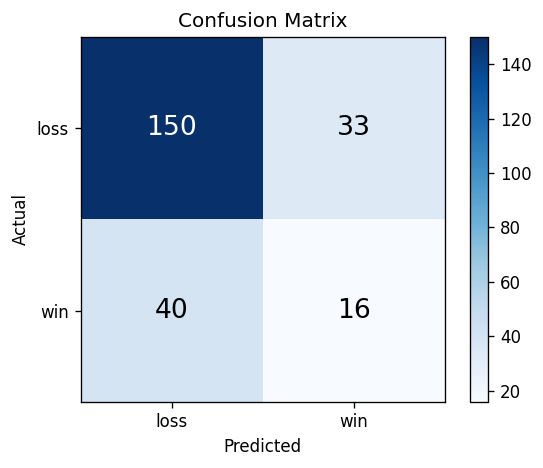

In [3]:
# Cell 3: Train XGBoost V1 & Evaluate
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
)
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["figure.dpi"] = 120

spw = (len(y_train) - y_train.sum()) / y_train.sum()

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    scale_pos_weight=spw,
    eval_metric="logloss",
    random_state=42,
    enable_categorical=False,
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("=== V1 Model Performance ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred, zero_division=0):.3f}")
print(f"F1 Score:  {f1_score(y_test, y_pred, zero_division=0):.3f}")
print(f"AUC-ROC:   {roc_auc_score(y_test, y_prob):.3f}")
print(f"\nBaseline (always predict loss): {1 - y_test.mean():.3f}")
print(f"\n{classification_report(y_test, y_pred, target_names=['loss', 'win'], zero_division=0)}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["loss", "win"])
ax.set_yticklabels(["loss", "win"])
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix")
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(cm[i, j]), ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2 else "black", fontsize=16)
plt.colorbar(im)
plt.tight_layout()
plt.show()

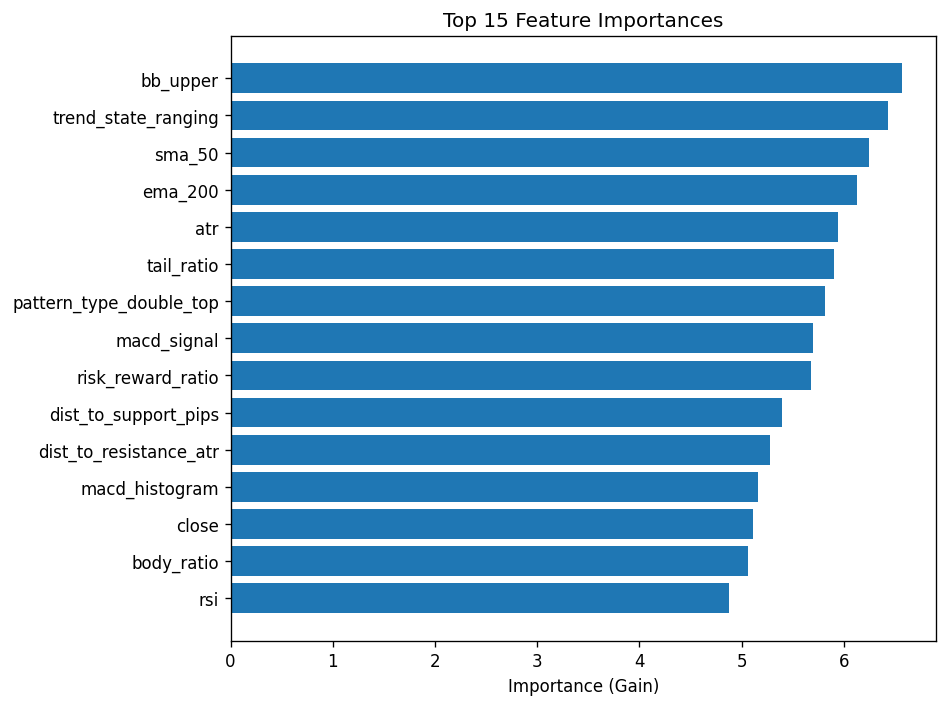


Top 15 features:
  bb_upper                       6.57
  trend_state_ranging            6.43
  sma_50                         6.24
  ema_200                        6.13
  atr                            5.94
  tail_ratio                     5.90
  pattern_type_double_top        5.82
  macd_signal                    5.70
  risk_reward_ratio              5.68
  dist_to_support_pips           5.40
  dist_to_resistance_atr         5.28
  macd_histogram                 5.16
  close                          5.11
  body_ratio                     5.06
  rsi                            4.88


In [4]:
# Cell 4: Feature Importance (Task 5.3)
importances = model.get_booster().get_score(importance_type="gain")
imp_df = pd.DataFrame(
    {"feature": importances.keys(), "importance": importances.values()}
).sort_values("importance", ascending=True)

top_n = min(15, len(imp_df))
top = imp_df.tail(top_n)

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(top["feature"], top["importance"])
ax.set_xlabel("Importance (Gain)")
ax.set_title(f"Top {top_n} Feature Importances")
plt.tight_layout()
plt.show()

print(f"\nTop {top_n} features:")
for _, row in imp_df.tail(top_n).iloc[::-1].iterrows():
    print(f"  {row['feature']:30s} {row['importance']:.2f}")

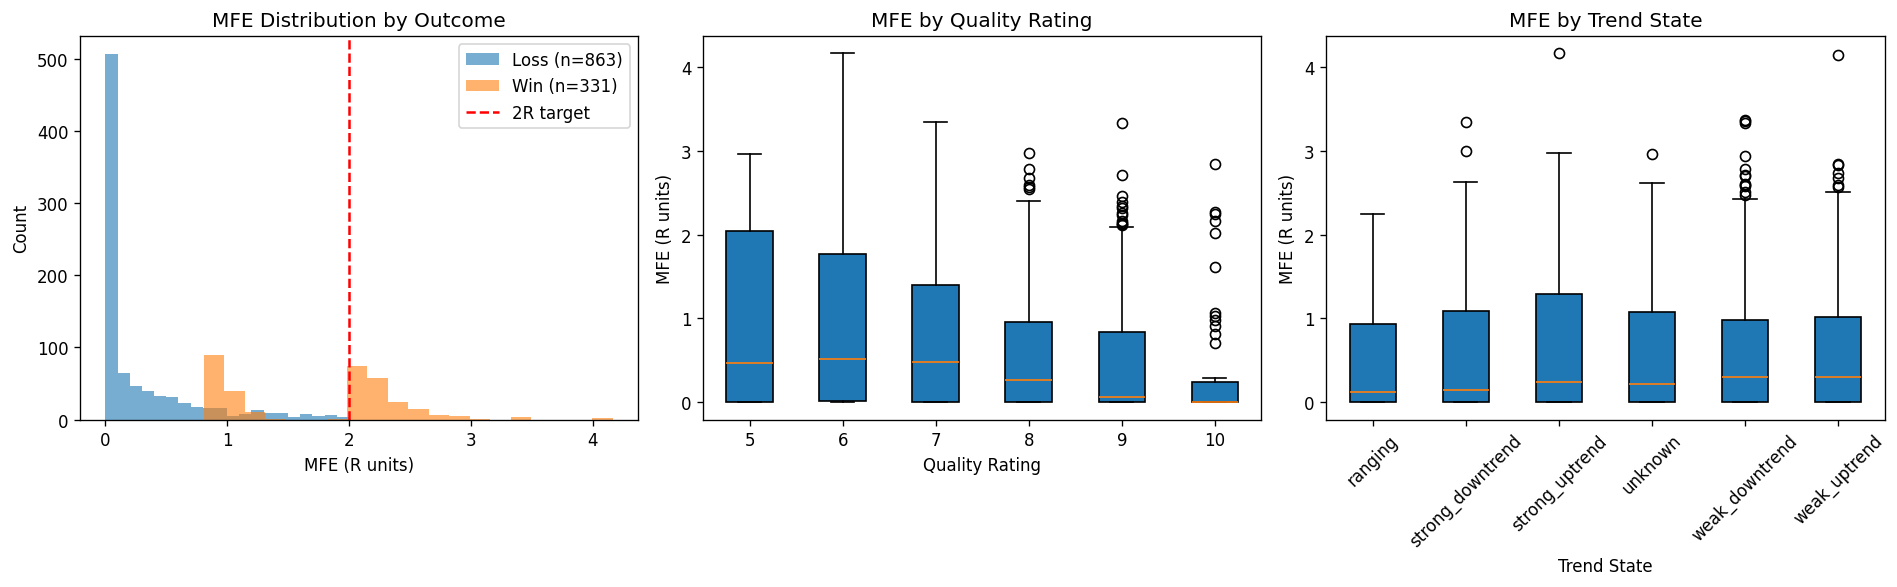

=== MFE Summary ===
Win  MFE: mean=1.72R, median=2.04R
Loss MFE: mean=0.26R, median=0.00R

Losses with MFE >= 1R: 70 / 863 (8.1%)
  ^ These are trades that moved favorably 1R+ but didn't reach 2R -- V2/V3 could capture these.

Losses with MFE >= 1.5R: 26 / 863 (3.0%)
  ^ Trades that nearly hit 2R -- strong case for dynamic TP.


In [5]:
# Cell 5: MFE Distribution Analysis (Task 5.3)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

wins_mfe = df_raw[df_raw["outcome"] == "win"]["max_favorable_excursion"]
losses_mfe = df_raw[df_raw["outcome"] == "loss"]["max_favorable_excursion"]

# 5a: MFE histogram by outcome
ax = axes[0]
ax.hist(losses_mfe, bins=20, alpha=0.6, label=f"Loss (n={len(losses_mfe)})")
ax.hist(wins_mfe, bins=20, alpha=0.6, label=f"Win (n={len(wins_mfe)})")
ax.axvline(x=2.0, color="red", linestyle="--", label="2R target")
ax.set_xlabel("MFE (R units)")
ax.set_ylabel("Count")
ax.set_title("MFE Distribution by Outcome")
ax.legend()

# 5b: MFE by quality rating
ax = axes[1]
quality_groups = df_raw.groupby("quality_rating")["max_favorable_excursion"]
labels_q = sorted(df_raw["quality_rating"].dropna().unique())
data_q = [quality_groups.get_group(q).dropna().values for q in labels_q]
bp = ax.boxplot(data_q, tick_labels=[str(int(q)) for q in labels_q], patch_artist=True)
ax.set_xlabel("Quality Rating")
ax.set_ylabel("MFE (R units)")
ax.set_title("MFE by Quality Rating")

# 5c: MFE by trend state
ax = axes[2]
trend_groups = df_raw.groupby("trend_state")["max_favorable_excursion"]
labels_t = sorted(df_raw["trend_state"].unique())
data_t = [trend_groups.get_group(t).dropna().values for t in labels_t if len(trend_groups.get_group(t).dropna()) > 0]
labels_t = [t for t in labels_t if len(trend_groups.get_group(t).dropna()) > 0]
bp2 = ax.boxplot(data_t, tick_labels=labels_t, patch_artist=True)
ax.tick_params(axis="x", rotation=45)
ax.set_xlabel("Trend State")
ax.set_ylabel("MFE (R units)")
ax.set_title("MFE by Trend State")

plt.tight_layout()
plt.show()

# Key MFE stats
print("=== MFE Summary ===")
print(f"Win  MFE: mean={wins_mfe.mean():.2f}R, median={wins_mfe.median():.2f}R")
print(f"Loss MFE: mean={losses_mfe.mean():.2f}R, median={losses_mfe.median():.2f}R")
print(f"\nLosses with MFE >= 1R: {(losses_mfe >= 1.0).sum()} / {len(losses_mfe)} ({(losses_mfe >= 1.0).mean():.1%})")
print("  ^ These are trades that moved favorably 1R+ but didn't reach 2R -- V2/V3 could capture these.")
print(f"\nLosses with MFE >= 1.5R: {(losses_mfe >= 1.5).sum()} / {len(losses_mfe)} ({(losses_mfe >= 1.5).mean():.1%})")
print("  ^ Trades that nearly hit 2R -- strong case for dynamic TP.")

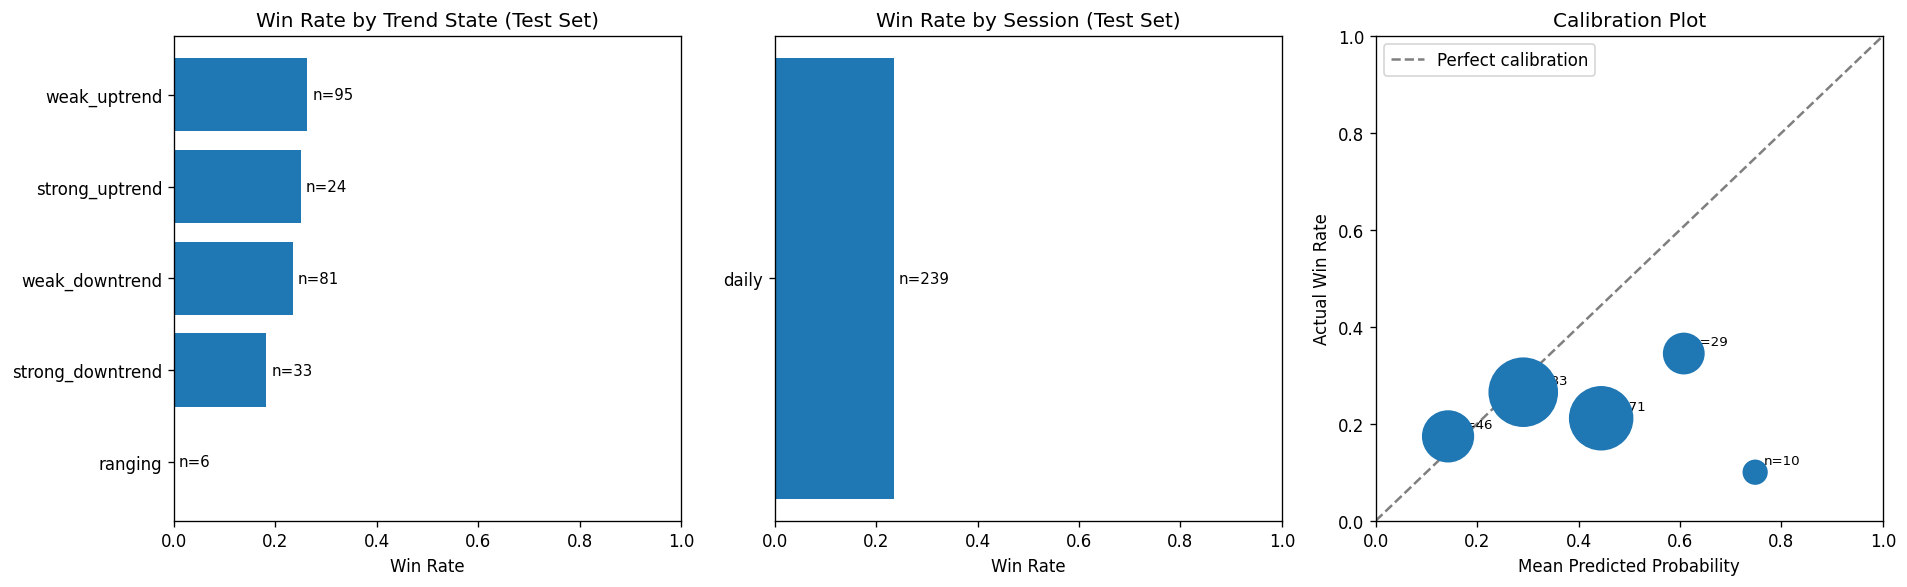

=== Context Performance (Full Dataset) ===

--- By Trend State ---
  ranging                    n= 52  win_rate=28.8%  avg_mfe=0.52R
  strong_downtrend           n=143  win_rate=22.4%  avg_mfe=0.64R
  strong_uptrend             n=117  win_rate=31.6%  avg_mfe=0.74R
  unknown                    n=101  win_rate=29.7%  avg_mfe=0.70R
  weak_downtrend             n=402  win_rate=26.4%  avg_mfe=0.65R
  weak_uptrend               n=379  win_rate=29.3%  avg_mfe=0.68R

--- By Session ---
  daily                      n=1194  win_rate=27.7%  avg_mfe=0.67R

--- By Quality Rating ---
  rating= 5  n=101  win_rate=31.7%  avg_mfe=0.93R
  rating= 6  n=188  win_rate=27.1%  avg_mfe=0.89R
  rating= 7  n=213  win_rate=29.6%  avg_mfe=0.81R
  rating= 8  n=323  win_rate=31.9%  avg_mfe=0.64R
  rating= 9  n=314  win_rate=23.2%  avg_mfe=0.44R
  rating=10  n= 55  win_rate=16.4%  avg_mfe=0.36R


In [6]:
# Cell 6: Context Performance Analysis (Task 5.4)
df_test_analysis = df_raw.iloc[split_idx:].copy()
df_test_analysis["predicted"] = y_pred
df_test_analysis["predicted_prob"] = y_prob
df_test_analysis["is_win"] = (df_test_analysis["outcome"] == "win").astype(int)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 6a: Win rate by trend state
ax = axes[0]
ts_stats = df_test_analysis.groupby("trend_state").agg(
    win_rate=("is_win", "mean"),
    count=("is_win", "count"),
)
ts_stats = ts_stats[ts_stats["count"] >= 2].sort_values("win_rate", ascending=True)
bars = ax.barh(ts_stats.index, ts_stats["win_rate"])
for bar, (_, row) in zip(bars, ts_stats.iterrows()):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
            f"n={int(row['count'])}", va="center", fontsize=9)
ax.set_xlabel("Win Rate")
ax.set_title("Win Rate by Trend State (Test Set)")
ax.set_xlim(0, 1)

# 6b: Win rate by session
ax = axes[1]
sess_stats = df_test_analysis.groupby("trading_session").agg(
    win_rate=("is_win", "mean"),
    count=("is_win", "count"),
)
sess_stats = sess_stats[sess_stats["count"] >= 2].sort_values("win_rate", ascending=True)
bars = ax.barh(sess_stats.index, sess_stats["win_rate"])
for bar, (_, row) in zip(bars, sess_stats.iterrows()):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
            f"n={int(row['count'])}", va="center", fontsize=9)
ax.set_xlabel("Win Rate")
ax.set_title("Win Rate by Session (Test Set)")
ax.set_xlim(0, 1)

# 6c: Calibration -- predicted prob vs actual win rate
ax = axes[2]
df_test_analysis["prob_bucket"] = pd.cut(df_test_analysis["predicted_prob"], bins=5)
cal = df_test_analysis.groupby("prob_bucket", observed=True).agg(
    mean_pred=("predicted_prob", "mean"),
    actual_rate=("is_win", "mean"),
    count=("is_win", "count"),
)
cal = cal[cal["count"] >= 2]
if len(cal) >= 2:
    ax.plot([0, 1], [0, 1], "k--", alpha=0.5, label="Perfect calibration")
    ax.scatter(cal["mean_pred"], cal["actual_rate"], s=cal["count"] * 20, zorder=5)
    for _, row in cal.iterrows():
        ax.annotate(f"n={int(row['count'])}",
                    (row["mean_pred"], row["actual_rate"]),
                    textcoords="offset points", xytext=(5, 5), fontsize=8)
    ax.set_xlabel("Mean Predicted Probability")
    ax.set_ylabel("Actual Win Rate")
    ax.set_title("Calibration Plot")
    ax.legend()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
else:
    ax.text(0.5, 0.5, "Not enough data\nfor calibration", ha="center", va="center", fontsize=12)
    ax.set_title("Calibration Plot")

plt.tight_layout()
plt.show()

# Full context breakdown
print("=== Context Performance (Full Dataset) ===")
df_full = df_raw.copy()
df_full["is_win"] = (df_full["outcome"] == "win").astype(int)

print("\n--- By Trend State ---")
for ts in sorted(df_full["trend_state"].unique()):
    sub = df_full[df_full["trend_state"] == ts]
    mfe = sub["max_favorable_excursion"].mean()
    print(f"  {ts:25s}  n={len(sub):3d}  win_rate={sub['is_win'].mean():.1%}  avg_mfe={mfe:.2f}R")

print("\n--- By Session ---")
for sess in sorted(df_full["trading_session"].dropna().unique()):
    sub = df_full[df_full["trading_session"] == sess]
    mfe = sub["max_favorable_excursion"].mean()
    print(f"  {sess:25s}  n={len(sub):3d}  win_rate={sub['is_win'].mean():.1%}  avg_mfe={mfe:.2f}R")

print("\n--- By Quality Rating ---")
for q in sorted(df_full["quality_rating"].unique()):
    sub = df_full[df_full["quality_rating"] == q]
    mfe = sub["max_favorable_excursion"].mean()
    print(f"  rating={int(q):2d}  n={len(sub):3d}  win_rate={sub['is_win'].mean():.1%}  avg_mfe={mfe:.2f}R")

In [7]:
# Cell 7: Save Model & Summary
import os
import json

model_dir = "/Users/muftau/Documents/programming/trading-ai/python/models"
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, "xgb_v1b_multipattern.json")
model.save_model(model_path)
print(f"Model saved to {model_path}")

meta_path = os.path.join(model_dir, "xgb_v1b_multipattern_meta.json")
with open(meta_path, "w") as f:
    json.dump({
        "features": feature_cols,
        "n_features": len(feature_cols),
        "train_size": len(X_train),
        "test_size": len(X_test),
        "class_balance": {"loss": int(len(y) - y.sum()), "win": int(y.sum())},
        "scale_pos_weight": float(spw),
    }, f, indent=2)
print(f"Feature metadata saved to {meta_path}")

print("\n=== V1b Training Complete ===")
print(f"Dataset:    {len(X)} rows ({len(X_train)} train / {len(X_test)} test)")
print(f"Features:   {len(feature_cols)}")
print(f"Accuracy:   {accuracy_score(y_test, y_pred):.3f} (baseline: {1 - y_test.mean():.3f})")
print(f"Precision:  {precision_score(y_test, y_pred, zero_division=0):.3f}")
print(f"Recall:     {recall_score(y_test, y_pred, zero_division=0):.3f}")
print(f"F1:         {f1_score(y_test, y_pred, zero_division=0):.3f}")
print(f"AUC-ROC:    {roc_auc_score(y_test, y_prob):.3f}")

Model saved to /Users/muftau/Documents/programming/trading-ai/python/models/xgb_v1b_multipattern.json
Feature metadata saved to /Users/muftau/Documents/programming/trading-ai/python/models/xgb_v1b_multipattern_meta.json

=== V1b Training Complete ===
Dataset:    1194 rows (955 train / 239 test)
Features:   36
Accuracy:   0.695 (baseline: 0.766)
Precision:  0.327
Recall:     0.286
F1:         0.305
AUC-ROC:    0.531
